# CS229: Problem Set 1
## Problem 1: Logistic Regression

**C. Combier**

This iPython Notebook provides solutions to Stanford's CS229 (Machine Learning, Fall 2017) graduate course problem set 1, taught by Andrew Ng.

The problem set can be found here: [./ps1.pdf](ps1.pdf)

I chose to write the solutions to the coding questions in Python, whereas the Stanford class is taught with Matlab/Octave.

## Notation

- $x^i$ is the $i^{th}$ feature vector
- $y^i$ is the expected outcome for the $i^{th}$ training example
- $m$ is the number of training examples
- $n$ is the number of features

Let's start by setting up our Python environment and importing the required libraries:

In [1]:
%matplotlib inline
import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes

#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns #sets up styles and gives us more plotting options

The goal of this problem is to implement Newton's method to solve a logistic regression problem. We consider the average empirical loss for logistic regression:

$$
J(\theta) = \frac{1}{m} \sum_{i=1}^m \log(1+e^{-y^i \theta^T x^i}) = -\frac{1}{m} \sum_{i=1}^m \log(h_{\theta}(y^i x^i))
$$

### Question 1.a)

Let's start by calculating the gradient of $J$:

$$
\frac{\partial}{\partial \theta_j} J(\theta)= -\frac{1}{m}.\sum_{i=1}^m (1-h_{\theta}(y^i x^i)).y^i.x_j^i
$$

The terms of the Hessian are $H_{j,k} = \frac{\partial^2}{\partial \theta_j \partial \theta_k} J(\theta)$:

$$
\begin{align*}
H_{j,k} &= \frac{1}{m}.\sum_{i=1}^m h_{\theta}(y^i x^i).(1-h_{\theta}(y^i x^i)).(y^i.x_j^i).(y^i.x_k^i)\\
&= \frac{1}{m}.\sum_{i=1}^m h_{\theta}(y^i x^i).(1-h_{\theta}(y^i x^i)).x_j^i.x_k^i
\end{align*}
$$

Furthermore:

$$
\begin{align*}
    \sum_i \sum_j z_i x_i x_j z_j &= \sum_i z_i x_i \sum_j x_j z_j \\
     &= (x^T z)(x^T z) \\
     &= (x^T z)^2
\end{align*}
$$

Now, we calculate $z^T H z$. Let $z \in R^n$ :

$$
\begin{align*}
z^T H z &= \sum_j \sum_k \frac{1}{m}.\sum_{i=1}^m h_{\theta}(y^i x^i).(1-h_{\theta}(y^i x^i)).(y^i.x_j^i).(y^i.x_k^i).z_j. z_k \\
&= \frac{1}{m}.\sum_{i=1}^m h_{\theta}(y^i x^i).(1-h_{\theta}(y^i x^i)).\sum_j (y^i x_j^i z_j).\sum_k (y^i x_k^i z_k) \\
&= \frac{1}{m}.\sum_{i=1}^m h_{\theta}(y^i x^i).(1-h_{\theta}(y^i x^i)))(z^T y^i x^i)^2
\end{align*}
$$

Since $\forall i$, $0 < h_{\theta}(y^i x^i) < 1$ and $\forall i$, $(z^T y^i x^i)^2 \geq 0$, this shows that $z^T H z \geq 0$. Since this is true $\forall z$, this concludes that:

$$
H \succeq	0
$$

i.e. $H$ is semidefinite positive.


### Question 1.b)

Let's start by loading the data into two pandas DataFrames:

In [2]:
df_x = pd.read_csv("./data/logistic_x.txt", sep="\ +", names=["x1","x2"], header=None, engine='python')
df_y = pd.read_csv('./data/logistic_y.txt', sep='\ +', names=["y"], header=None, engine='python')
df_y = df_y.astype(int)
df_x.head()

,x1,x2
0,1.343250,-1.331148
1,1.820553,-0.634668
2,0.986321,-1.888576
3,1.944373,-1.635452
4,0.976734,-1.353315


Let's get the NumPy arrays from the dataset, and add a column of 1's to $X$ to take into account the zero intercept

In [3]:
x = np.hstack([np.ones((df_x.shape[0], 1)), df_x[["x1","x2"]].values])
y = df_y["y"].values

Define our Sigmoid, Gradient, and Hessian functions:

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def grad_l(theta, x, y):
    z = y*x.dot(theta)
    g = -np.mean((1-sigmoid(z))*y*x.T, axis=1)
    return g

def hess_l(theta, x, y):
    hess = np.zeros((x.shape[1], x.shape[1]))
    z = y*x.dot(theta)
    for i in range(hess.shape[0]):
        for j in range(hess.shape[0]):
            if i <= j:
                hess[i][j] = np.mean(sigmoid(z)*(1-sigmoid(z))*x[:,i]*x[:,j])
                if i != j:
                    hess[j][i] = hess[i][j] 
    return hess

Now let's write Newton's method into a Python function. Newton's method has the following update rule:

$$
\begin{align*}
    \theta := \theta - H^{-1} \nabla_{\theta} J(\theta)
\end{align*}
$$

In [5]:
def newton(theta0, x, y, G, H, eps):
    theta = theta0
    delta = 1
    while delta > eps:
        theta_prev = theta.copy()
        theta -= np.linalg.inv(H(theta, x, y)).dot(G(theta, x, y))
        delta = np.linalg.norm(theta-theta_prev, ord=1)
    return theta

We can now run Newton's method to perform logistic regression:

In [6]:
# Initialize theta0
theta0 = np.zeros(x.shape[1])

# Run Newton's method
theta_final = newton(theta0,x,y,grad_l,hess_l,1e-6)
print theta_final

[-2.6205116   0.76037154  1.17194674]


### Question 1.c)

Plot the data and our decision boundary:

In [7]:
df_x.insert(0, "y", df_y)
df_x["y"] = pd.to_numeric(df_x["y"],downcast='signed')
df_x.head()

,y,x1,x2
0,-1,1.343250,-1.331148
1,-1,1.820553,-0.634668
2,-1,0.986321,-1.888576
3,-1,1.944373,-1.635452
4,-1,0.976734,-1.353315


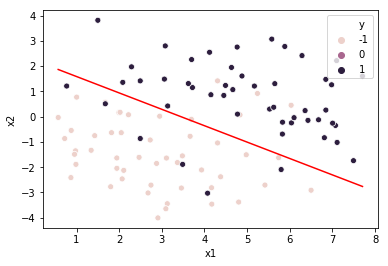

In [8]:
# Generate vector to plot decision boundary
x1_vec = np.linspace(df_x["x1"].min(),df_x["x1"].max(),2);

# Plot raw data
sns.scatterplot(x="x1", y="x2", hue="y", data=df_x);

# Plot decision boundary
plt.plot(x1_vec,(-x1_vec*theta_final[1]-theta_final[0])/theta_final[2], color="red");